<a href="https://colab.research.google.com/github/GaikwadSandesh/Coronavirus-Tweet-Sentiment-Analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

# Data loading and Cleaning

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report,confusion_matrix , accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
import string
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/Coronavirus Tweets.csv' ,encoding='latin-1')

In [4]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

 * UserName and ScreenName are very much like id of The screen which are irevent to our problem

In [5]:
df.drop(columns=['ScreenName' ,'UserName' , ]  , inplace=True)

In [6]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Location       32567 non-null  object
 1   TweetAt        41157 non-null  object
 2   OriginalTweet  41157 non-null  object
 3   Sentiment      41157 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


In [8]:
df.isnull().sum()

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [9]:
print(round(100*(df.isnull().sum()/len(df.index)),2))

Location         20.87
TweetAt           0.00
OriginalTweet     0.00
Sentiment         0.00
dtype: float64


* Location and Tweet time are also not nedded for the problem but we will do some basic EDA just to understand what type of data we are going through

### Tweet by date

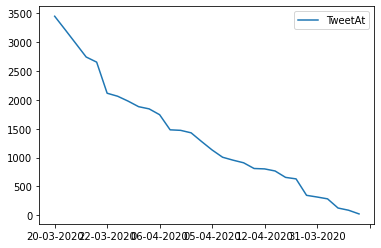

In [10]:
df['TweetAt'].value_counts().to_frame().plot(kind = 'line')

### Top Location of Tweets

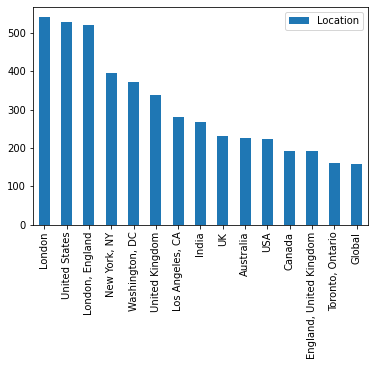

In [11]:
df['Location'].value_counts().sort_values(ascending=False).to_frame().iloc[:15].plot(kind ='bar')


In [12]:
#df.dropna()['Location'].value_counts().to_frame().head(25)

In [13]:
df.drop(columns=['Location' ,'TweetAt'] , inplace=True) # we don't need Location and tweet date so we will drop this columns

In [14]:
pd.concat([df.head(3), df.tail(3)], axis=0)

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,@TartiiCat Well new/used Rift S are going for ...,Negative


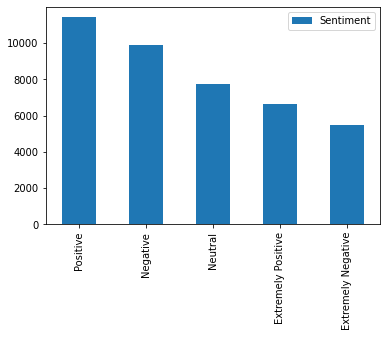

In [15]:
df['Sentiment'].value_counts().to_frame().plot(kind = 'bar')

We will ony consider tweet column and use NLP based approch to build classifier

# Preprocessing of Tweets column

In [16]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [17]:
import nltk
nltk.download('stopwords')
sw = stopwords.words('english') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [19]:
def remove_pattern(input_txt, pattern):
    '''a function to remove tags and user '''
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [20]:
def seniment_encoding(Sentiment):
  value = 0
  if Sentiment == 'Extremely Negative':
    value = -3 
  elif Sentiment == 'Negative':
    value = -2 
  elif   Sentiment == 'Extremely Positive':   
    value = 3
  elif Sentiment == 'Positive':
    value = 2
  else:
      pass
  return value

In [21]:
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [22]:
df['filtered'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [23]:
df['filtered'] = df['filtered'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [24]:
df['filtered'] = df['OriginalTweet'].apply(remove_punctuation)

In [25]:
df['filtered'] = df['filtered'].apply(stopwords)

In [26]:
df['filtered'] = df['filtered'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [27]:
df_binary =df.copy()

In [28]:
df['encode_senti'] =  df['Sentiment'].apply(seniment_encoding)

In [29]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt) 
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['filtered'] , df['encode_senti'],test_size=0.3 , random_state=42)

In [31]:
def evaluation_metrics(y_train , y_train_p ,y_test, y_test_p):
  ''' a function to get classification report , 
  heat map , and other errors '''
  MSE_train  = round(mean_squared_error(y_test, y_test_p), 2)
  print("MSE train:" , MSE_train)
  MSE_test  = round(mean_squared_error(y_train, y_train_p), 2)
  print("MSE test:" , MSE_test)

  RMSE_train = round(np.sqrt(MSE_train), 2)
  print("RMSE train:" ,RMSE_train)
  RMSE_test = round(np.sqrt(MSE_test), 2)
  print("RMSE test:" ,RMSE_test)


  print("classification report train data")
  print(classification_report(y_train,y_train_p))
  print("\n")
  print("classification report test data")
  print(classification_report(y_test,y_test_p))

  print("Training accuracy Score   : ",accuracy_score(y_train,y_train_p))
  print("Validation accuracy Score : ",accuracy_score(y_test, y_test_p))
  
  print("\n")

  labels = {-4 :'Extremely Negative', -1:'Negative', 0:'Neutral' , 1:'Positive',
       4 :'Extremely Positive'}
  confusion_matrix = metrics.confusion_matrix(y_test, y_test_p  , labels = [-3 , -2 , 0 , 2 , 3])
  sns.heatmap(confusion_matrix, annot=True, fmt="d" , xticklabels=labels , yticklabels=labels)

  plt.xlabel("Predicted Label", fontsize= 12)
  plt.ylabel("True Label", fontsize= 12)

  plt.show()



# Vectoriser

In [32]:
# create a count vectorizer object
count_vectorizer = CountVectorizer(max_df =0.9 , min_df = 10)
# fit the count vectorizer using the text data
count_vectorizer.fit(X_train)

CountVectorizer(max_df=0.9, min_df=10)

In [33]:
train_cv_vectorized = count_vectorizer.transform(X_train)
test_cv_vectorized = count_vectorizer.transform(X_test)
train_cv_array= train_cv_vectorized.toarray()
test_cv_array = test_cv_vectorized.toarray()

In [34]:
train_cv_array.shape

(28809, 5242)

In [35]:
# create a count vectorizer object
Tfidf_vectorizer = TfidfVectorizer(max_df =0.9, min_df = 10)
# fit the count vectorizer using the text data
Tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.9, min_df=10)

In [36]:
train_tfidf_vectorized = Tfidf_vectorizer.transform(X_train)
test_tfidf_vectorized = Tfidf_vectorizer.transform(X_test)
train_tfidf_array= train_tfidf_vectorized.toarray()
test_tfidf_array = test_tfidf_vectorized.toarray()

In [37]:
train_tfidf_array.shape

(28809, 5242)

# Naive Bayes 

## Naive bayes Count Vectoriser

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NBC_model = MultinomialNB().fit(train_cv_array,y_train)

In [ ]:
train_preds = NBC_model.predict(train_cv_array)
test_preds = NBC_model.predict(test_cv_array)

In [ ]:
evaluation_metrics(y_train, train_preds , y_test , test_preds)

## Naive Baye TFidf vectoriser 

In [ ]:
NBT_model = MultinomialNB().fit(train_tfidf_array,y_train)

In [ ]:
train_preds = NBT_model.predict(train_tfidf_array)
test_preds = NBT_model.predict(test_tfidf_array)

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# Random forest Classifier (tfidf_vectorizer)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()


In [ ]:
# Create the random grid
# param_grid = {'n_estimators': [15],
#                'max_depth': [ 50 , 80],
#                'min_samples_split': [6 ],
#                'min_samples_leaf': [4 ,6 ]}
param_grid = {'n_estimators': [15],
               'max_depth': [ 80],
               'min_samples_split': [6 ],
               'min_samples_leaf': [4 ]}

In [ ]:
grid_rf_clf = GridSearchCV(rf_clf, param_grid, cv=5)

In [ ]:
grid_rf_clf.fit(train_tfidf_array,y_train)

In [ ]:
grid_rf_clf.best_params_

In [48]:
train_preds = grid_rf_clf.predict(train_tfidf_array)
test_preds = grid_rf_clf.predict(test_tfidf_array)

NameError: ignored

In [ ]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# catboost

In [38]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [39]:
from catboost import CatBoostClassifier

In [40]:
# we will agin split the data to get validation set
X_train_c, X_eval,y_train_c,y_eval = train_test_split(train_tfidf_array , y_train,test_size=0.2 , random_state=42)

In [41]:
cb_clf= CatBoostClassifier()

In [42]:
cb_clf.fit(X_train_c, y_train_c,  
        eval_set=(X_eval, y_eval), 
        verbose=False
)

In [43]:
train_preds = cb_clf.predict(train_tfidf_array)
test_preds = cb_clf.predict(test_tfidf_array)

MSE train: 2.91
MSE test: 2.33
RMSE train: 1.71
RMSE test: 1.53
classification report train data
              precision    recall  f1-score   support

          -3       0.74      0.58      0.65      3909
          -2       0.62      0.60      0.61      6912
           0       0.65      0.78      0.71      5421
           2       0.62      0.70      0.66      7932
           3       0.79      0.61      0.69      4635

    accuracy                           0.66     28809
   macro avg       0.68      0.65      0.66     28809
weighted avg       0.67      0.66      0.66     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.64      0.49      0.55      1572
          -2       0.53      0.49      0.51      3005
           0       0.60      0.75      0.66      2292
           2       0.54      0.61      0.57      3490
           3       0.70      0.51      0.59      1989

    accuracy                           0.58     12348


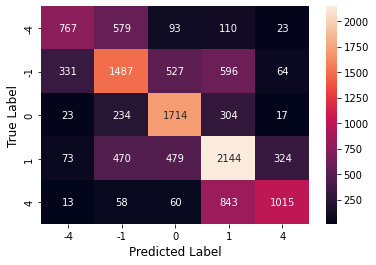

In [49]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

In [46]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/catboost_model' , 'wb') as f:
  pickle.dump(cb_clf,f)

In [47]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/catboost_model' , 'rb') as f:
  catboost_model = pickle.load(f)

In [50]:
train_preds = catboost_model.predict(train_tfidf_array)
test_preds = catboost_model.predict(test_tfidf_array)

MSE train: 2.91
MSE test: 2.33
RMSE train: 1.71
RMSE test: 1.53
classification report train data
              precision    recall  f1-score   support

          -3       0.74      0.58      0.65      3909
          -2       0.62      0.60      0.61      6912
           0       0.65      0.78      0.71      5421
           2       0.62      0.70      0.66      7932
           3       0.79      0.61      0.69      4635

    accuracy                           0.66     28809
   macro avg       0.68      0.65      0.66     28809
weighted avg       0.67      0.66      0.66     28809



classification report test data
              precision    recall  f1-score   support

          -3       0.64      0.49      0.55      1572
          -2       0.53      0.49      0.51      3005
           0       0.60      0.75      0.66      2292
           2       0.54      0.61      0.57      3490
           3       0.70      0.51      0.59      1989

    accuracy                           0.58     12348


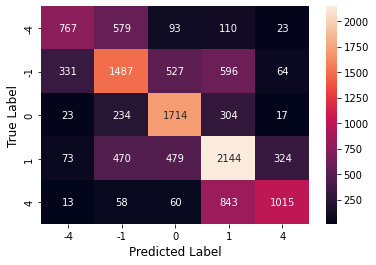

In [51]:
evaluation_metrics(y_train, train_preds, y_test, test_preds)

# SVM

In [38]:
from sklearn.svm import SVC

svc = SVC()

In [39]:
train_tfidf_array.shape

(28809, 5242)

In [40]:
svc.fit(train_tfidf_array[:15000 , :],y_train[ :15000]) # svc on all data is running out of ram so we will only use first 15000 tweets

SVC()

In [ ]:
train_preds = svc.predict(train_cv_array)
test_preds = svc.predict(test_cv_array)

In [ ]:
evaluation_metrics(y_train, train_preds , y_test , test_preds)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/svc_model' , 'wb') as f:
  pickle.dump(svc,f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/svc_model' , 'rb') as f:
  svc_model = pickle.load(f)

# logistic regression multiclass

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg_clf = LogisticRegression(max_itr = 200)

In [ ]:
log_reg_clf.fit(train_tfidf_array,y_train)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Alma_better/Twitter sentiments/log_reg_model' , 'wb') as f:
  pickle.dump(log_reg_clf,f)

In [ ]:
train_preds = log_reg_clf.predict(train_cv_array)
test_preds = log_reg_clf.predict(test_cv_array)

In [ ]:
evaluation_metrics(y_train, train_preds , y_test , test_preds)

Deep Neural Network 

# Reduce MSE

We will do two stage classification 
First positive , extremly positive , Neutral
then negative extremly negative 

the again muticlass for posive and Binary for Negative

In [ ]:
def Binary_encoding(Sentiment):
  value = 1
  if Sentiment == 'Extremely Negative':
    value = 0
  elif Sentiment == 'Negative':
    value = 0 
  elif   Sentiment == 'Extremely Positive':   
    value = 1
  elif Sentiment == 'Positive':
    value = 1
  else:
      pass
  return value

# Multiclass to binary